<a href="https://colab.research.google.com/github/abeersethia/CCM_EEG/blob/main/LightweightUNetCompression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q torch torchvision torchaudio

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import random

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.8 MB/s eta 0:00:00


In [3]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(42)

In [2]:
def generate_lorenz(sigma=10.0, beta=8/3, rho=28.0, dt=0.01, T=50.0, init=(1.0,1.0,1.0)):
    def lorenz(t, state):
        x, y, z = state
        dx = sigma*(y - x)
        dy = x*(rho - z) - y
        dz = x*y - beta*z
        return [dx, dy, dz]
    t_eval = np.arange(0, T, dt)
    sol = solve_ivp(lorenz, (0, T), init, t_eval=t_eval, rtol=1e-9, atol=1e-9)
    traj = sol.y.T  # shape (N, 3)
    return traj, t_eval

In [4]:
def build_hankel_rows(signal, window_len, stride=1):
    """Return array (N_windows, window_len) of overlapping windows (rows of Hankel)."""
    T = len(signal)
    starts = list(range(0, T - window_len + 1, stride))
    rows = np.stack([signal[s:s+window_len] for s in starts], axis=0)
    return rows, starts  # rows shape (N, L), starts list length N

In [5]:
class HankelWindowDataset(Dataset):
    def __init__(self, signal, window_len=1024, stride=64, normalize=True):
        # signal: 1D np array
        self.signal = signal.astype(np.float32)
        self.window_len = window_len
        self.stride = stride
        self.rows, self.starts = build_hankel_rows(self.signal, window_len, stride)
        # inputs = hankel rows, targets = the same time-domain window (no Hankel output)
        self.inputs = self.rows[:, None, :]  # shape (N, 1, L)
        self.targets = self.rows[:, None, :] # same shape
        if normalize:
            self.mean = self.inputs.mean()
            self.std = self.inputs.std() + 1e-8
            self.inputs = (self.inputs - self.mean) / self.std
            self.targets = (self.targets - self.mean) / self.std
        else:
            self.mean = 0.0
            self.std = 1.0

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):
        # return tensors (input_hankel_row, target_time_window)
        return torch.from_numpy(self.inputs[idx]).float(), torch.from_numpy(self.targets[idx]).float()

In [6]:
class ConvBlock1D(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, padding=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.net(x)

class LightweightEncoderDecoder(nn.Module):
    def __init__(self, input_channels=1, base_channels=16, depth=3, latent_dim=32, input_length=1024):
        """
        Encoder: repeated ConvBlock + downsample (stride-2 conv)
        Bottleneck: flatten -> linear -> latent_dim
        Decoder: linear -> unflatten -> ConvTranspose upsampling -> conv blocks
        No skip connections.
        """
        super().__init__()
        self.depth = depth
        self.input_length = input_length

        # build encoder blocks (conv blocks + downsample)
        enc_layers = []
        in_ch = input_channels
        enc_chs = []
        curr_len = input_length
        for i in range(depth):
            out_ch = base_channels * (2 ** i)
            enc_layers.append(ConvBlock1D(in_ch, out_ch))
            # downsample with stride-2 conv to halve length
            enc_layers.append(nn.Conv1d(out_ch, out_ch, kernel_size=4, stride=2, padding=1))
            in_ch = out_ch
            enc_chs.append(out_ch)
            # update length after conv with kernel=4 stride=2 padding=1:
            curr_len = (curr_len + 2*1 - 4) // 2 + 1
        self.encoder = nn.Sequential(*enc_layers)
        self.enc_out_ch = enc_chs[-1]
        self.enc_out_len = curr_len
        self.flatten_dim = self.enc_out_ch * self.enc_out_len

        # bottleneck
        self.to_latent = nn.Linear(self.flatten_dim, latent_dim)
        self.from_latent = nn.Linear(latent_dim, self.flatten_dim)

        # decoder: mirror encoder channel sizes reversed
        # after unflatten we have (B, enc_out_ch, enc_out_len)
        dec_layers = []
        in_ch = self.enc_out_ch
        curr_len = self.enc_out_len
        # for each level (reverse)
        for i in reversed(range(depth)):
            out_ch = base_channels * (2 ** i)
            # upsample with ConvTranspose1d kernel=4 stride=2 padding=1 (inverse of downsample)
            dec_layers.append(nn.ConvTranspose1d(in_ch, out_ch, kernel_size=4, stride=2, padding=1))
            dec_layers.append(ConvBlock1D(out_ch, out_ch))
            in_ch = out_ch
            curr_len = curr_len * 2  # inverse of earlier downsampling (should match)
        self.decoder = nn.Sequential(*dec_layers)

        # final conv to single-channel time-domain window
        self.final_conv = nn.Conv1d(in_ch, 1, kernel_size=1)

        # store for checks
        self._expected_output_length = curr_len

    def forward(self, x):
        # x: (B, 1, L)
        h = self.encoder(x)              # (B, enc_out_ch, enc_out_len)
        b, c, l = h.shape
        h_flat = h.view(b, -1)          # (B, flatten_dim)
        z = self.to_latent(h_flat)      # (B, latent_dim)
        # from latent to decoder initial
        h2 = self.from_latent(z).view(b, c, l)
        out = self.decoder(h2)
        out = self.final_conv(out)
        # if output length mismatches input_length, crop or pad to input_length
        if out.shape[-1] != self.input_length:
            Lout = out.shape[-1]
            Lin = self.input_length
            if Lout > Lin:
                out = out[:, :, :Lin]
            else:
                pad = Lin - Lout
                out = nn.functional.pad(out, (0, pad))
        return out, z


In [7]:
def train_model(model, dataloader, n_epochs=30, lr=1e-3, device='cpu', print_every=1):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    for epoch in range(1, n_epochs+1):
        t0 = time.time()
        model.train()
        running = 0.0
        for xb, yb in dataloader:
            xb = xb.to(device)   # (B,1,L)
            yb = yb.to(device)   # (B,1,L)
            opt.zero_grad()
            pred, z = model(xb)
            loss = mse(pred, yb)
            loss.backward()
            opt.step()
            running += loss.item() * xb.size(0)
        avg = running / len(dataloader.dataset)
        if epoch % print_every == 0 or epoch==1:
            print(f"Epoch {epoch}/{n_epochs} - MSE {avg:.6e}  time={(time.time()-t0):.2f}s")
    return model

def overlap_add_reconstruct(pred_windows, starts, T):
    """
    pred_windows: numpy array (N, 1, L) predicted windows (in original scale)
    starts: list of start indices for each window
    T: total length of original signal
    returns: reconstructed 1D array length T (averaged over overlaps)
    """
    recon_agg = np.zeros(T, dtype=np.float32)
    counts = np.zeros(T, dtype=np.float32)
    N, _, L = pred_windows.shape
    for i in range(N):
        s = starts[i]
        recon_agg[s:s+L] += pred_windows[i,0]
        counts[s:s+L] += 1.0
    mask = counts > 0
    recon = np.zeros_like(recon_agg)
    recon[mask] = recon_agg[mask] / counts[mask]
    return recon

In [8]:
def run_experiment(
    T=200.0, dt=0.01, window_len=1024, stride=64, base_channels=16,
    depth=3, latent_dim=32, n_epochs=30, batch_size=64, lr=1e-3, use_cuda=True
):
    # generate lorenz (long)
    traj, t = generate_lorenz(dt=dt, T=T, init=(0.1,0.0,0.0))
    x = traj[:,0]  # observed 1D signal (x coordinate)
    print("Generated Lorenz:", traj.shape, "using x(t) length:", len(x))

    # dataset
    ds = HankelWindowDataset(x, window_len=window_len, stride=stride, normalize=True)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=True)
    device = 'cuda' if torch.cuda.is_available() and use_cuda else 'cpu'
    # model
    model = LightweightEncoderDecoder(input_channels=1, base_channels=base_channels,
                                      depth=depth, latent_dim=latent_dim, input_length=window_len)
    print("Model params:", sum(p.numel() for p in model.parameters() if p.requires_grad))
    # train
    model = train_model(model, dl, n_epochs=n_epochs, lr=lr, device=device)
    # evaluate: predict for all windows (in batches)
    model.eval()
    X_all = torch.from_numpy(ds.inputs).float()  # (N,1,L) normalized
    with torch.no_grad():
        preds = []
        bs = 128
        for i in range(0, X_all.shape[0], bs):
            xb = X_all[i:i+bs].to(device)
            p, _ = model(xb)
            preds.append(p.cpu().numpy())
        preds = np.concatenate(preds, axis=0)  # (N,1,L)
    # unnormalize
    preds = preds * ds.std + ds.mean
    # stitch back
    recon = overlap_add_reconstruct(preds, ds.starts, len(x))
    # compute metrics
    mse = np.mean((recon - x)**2)
    rmse = np.sqrt(mse)
    corr = np.corrcoef(recon, x)[0,1]
    print(f"Final reconstruction RMSE={rmse:.6e}, corr={corr:.4f}")
    # plot a segment
    Lplot = min(4000, len(x))
    plt.figure(figsize=(12,3))
    plt.plot(x[:Lplot], label='original x(t)', linewidth=1)
    plt.plot(recon[:Lplot], label='reconstructed x̂(t)', linewidth=1, alpha=0.8)
    plt.legend(); plt.title('Time domain reconstruction (segment)')
    plt.show()

    # attractor comparison via Takens embedding (m=3, tau chosen)
    def delay_embed_3d(sig, m=3, tau=8):
        N = len(sig) - (m-1)*tau
        emb = np.zeros((N, m))
        for i in range(m):
            emb[:,i] = sig[i*tau : i*tau + N]
        return emb
    tau = max(1, int(0.05 / dt))  # choose tau ~50ms in samples (heuristic)
    orig_emb = delay_embed_3d(x, m=3, tau=tau)
    rec_emb = delay_embed_3d(recon, m=3, tau=tau)
    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot(orig_emb[:,0], orig_emb[:,1], orig_emb[:,2], lw=0.3)
    ax1.set_title('Original attractor (Takens embed)')
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot(rec_emb[:,0], rec_emb[:,1], rec_emb[:,2], lw=0.3)
    ax2.set_title('Reconstructed attractor (from decoded signal)')
    plt.show()
    return model, ds, x, recon

Generated Lorenz: (12000, 3) using x(t) length: 12000
Model params: 638337
Epoch 1/40 - MSE 1.084105e+00  time=1.65s
Epoch 2/40 - MSE 9.269984e-01  time=0.92s
Epoch 3/40 - MSE 8.453361e-01  time=0.91s
Epoch 4/40 - MSE 8.056650e-01  time=0.92s
Epoch 5/40 - MSE 7.557015e-01  time=0.91s
Epoch 6/40 - MSE 7.135031e-01  time=0.97s
Epoch 7/40 - MSE 6.506746e-01  time=0.92s
Epoch 8/40 - MSE 5.938809e-01  time=1.32s
Epoch 9/40 - MSE 5.273204e-01  time=1.28s
Epoch 10/40 - MSE 4.778456e-01  time=1.26s
Epoch 11/40 - MSE 4.240634e-01  time=1.08s
Epoch 12/40 - MSE 3.792904e-01  time=0.92s
Epoch 13/40 - MSE 3.425695e-01  time=0.90s
Epoch 14/40 - MSE 3.226192e-01  time=0.91s
Epoch 15/40 - MSE 2.957929e-01  time=0.93s
Epoch 16/40 - MSE 2.735420e-01  time=0.92s
Epoch 17/40 - MSE 2.590471e-01  time=1.23s
Epoch 18/40 - MSE 2.443208e-01  time=0.94s
Epoch 19/40 - MSE 2.398485e-01  time=0.93s
Epoch 20/40 - MSE 2.207664e-01  time=1.29s
Epoch 21/40 - MSE 2.108269e-01  time=1.32s
Epoch 22/40 - MSE 2.045000e-01 

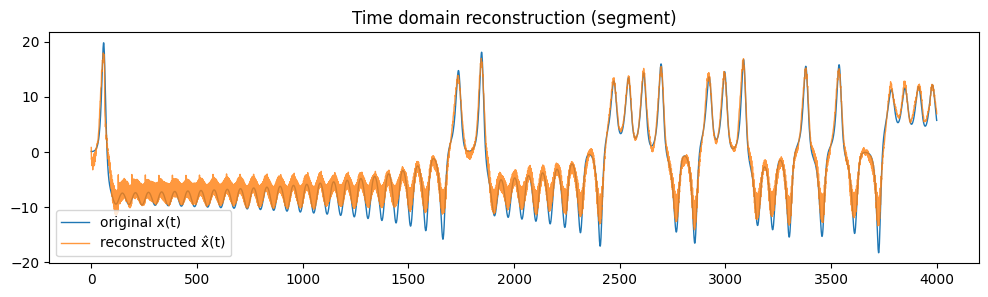

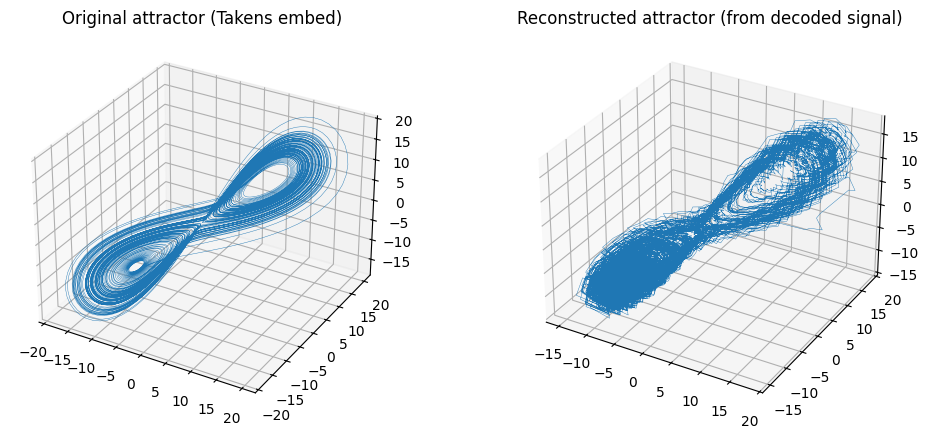

In [9]:
if __name__ == "__main__":
    # defaults chosen to be reasonable for CPU/GPU; reduce sizes if you run out of memory
    m, ds, orig_x, recon_x = run_experiment(
        T=120.0,       # seconds of simulation (longer -> more data)
        dt=0.01,       # integration timestep
        window_len=1024,
        stride=64,
        base_channels=16,
        depth=3,
        latent_dim=32,
        n_epochs=40,
        batch_size=64,
        lr=1e-3,
        use_cuda=True
    )